# Low Frequency Component Analysis

Wills et al. (2019, GRL)

The objective of LFCA is to find spatiotemporal patterns of variability that maximize the ratio of some frequency to total variability.

Wills et al. applied this methodology to SST to extricate global warming, the PDO, and ENSO from one another-- the intention of this notebook is to apply the same analysis to sea ice. 

### Developing the method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.signal as signal

In [2]:
time  = 4000
space = 40000

n_samples = time*space
mu = 0.5
corr = 0.5
sigma_0 = 1

In [3]:
c = mu * (1-corr)
sigma = np.sqrt((sigma_0 ** 2) * (1 - corr ** 2))
signal = [c + np.random.normal(0, sigma)]

signal = [c + corr * signal[-1] + np.random.normal(0, sigma) for _ in range(1, n_samples)]
signal.append(0)
X = np.reshape(signal, (time,space))

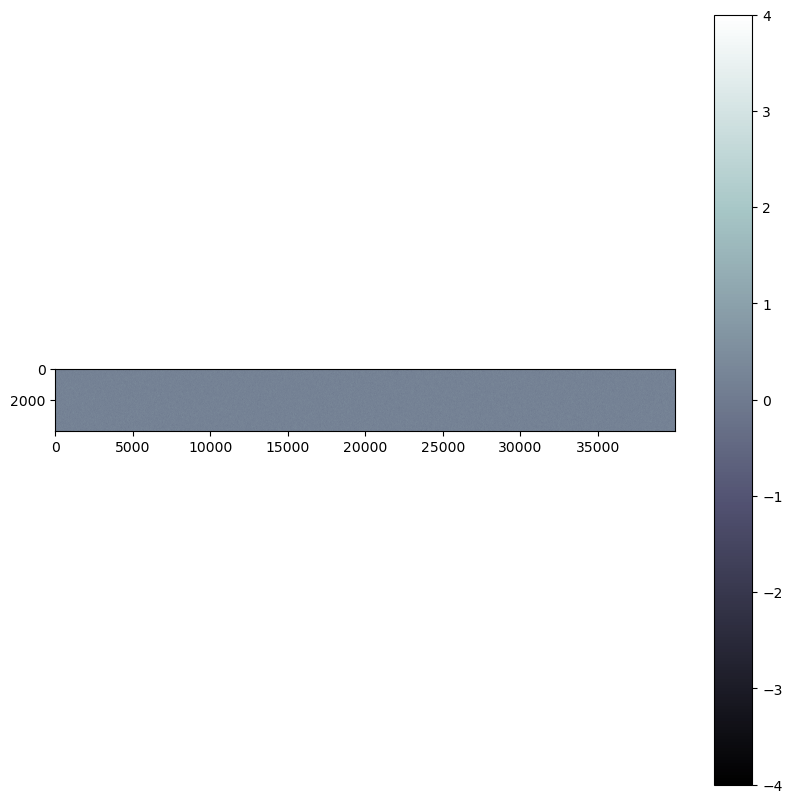

In [4]:
plt.figure(figsize = (10,10))
plt.imshow(X, vmin = -4, vmax = 4, cmap = 'bone')
plt.colorbar()
plt.show()

In [2]:
data = xr.open_dataset('/glade/work/mollyw/Projects/sea_ice_covariability/data/cryosat-2/piomas/piomas_daily_data.nc')

In [3]:
SIT = data.sithick

In [4]:
area = data.grid_area

In [5]:
def deseasonalize(data):
    
    deseasonalized = data.groupby('time.month') - data.groupby('time.month').mean(dim='time')
    
    return deseasonalized

In [6]:
dsd = deseasonalize(SIT)
weighted = dsd * np.sqrt(area)
X = weighted.stack({'space':('x','y')}).values

/glade/u/home/mollyw/.conda/envs/sicov/lib/python3.10/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [7]:
X[np.isnan(X)] = 0

In [5]:
def conventional_pca(X, Y):
    
    # extract the number of time samples from the data
    time = np.shape(X)[0]
    
    # define the covariance matrix
    C = 1 / (time - 1) * X.T @ Y
    
    # perform an eigen decomposition on the covariance matrix
    variance, EOFs = np.linalg.eig(C)
    
    # calculate the principal components associated with each EOF
    sigma = np.sqrt(variance)
    PCs = sigma**-1 * X @ EOFs
    
    return C, EOFs, variance, PCs

In [6]:
def butter_lowpass(cutoff, fs, order=4):
    nyq_freq = 0.5 * fs
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, fs, order=4):
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    b, a = butter_lowpass(cutoff_freq, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


In [7]:
def lfca(X, Y, years, nEOFs):
    
    C, EOFs, variance, PCs = conventional_pca(X,Y)
    
    fs = 1 
    cutoff = 1 / (years)
    
    PCs_tilda = butterworth_filter(PCs, cutOff, fs)
    R = np.cov(PCs_tilda.T)
    v, e = np.linalg.eig(R)
    
    EOFs_norm = EOFs[0:nEOFs,:].T/np.sqrt(variance[0:nEOF])
    u = EOFs_norm.T * e[0:nEOFs]
    
    LFCs = X   @ u.T
    LFPs = X.T @ LFCs
    fraction = v[0:nEOFs]
    
    return EOFs, PCs, variance, LFCs, LFPs, fraction

In [ ]:
EOFs, PCs, variance, LFCs, LFPs, fraction = lfca(X, X, 5, 3)

In [ ]:
fig, axes = plt.subplots(ncols = 3, figsize = (15,10))
for i in range(0,3):
    axes[i].imshow(np.reshape(LFPs[:,i], (10,10)), vmin  = -75,vmax = 75, cmap = 'Spectral')


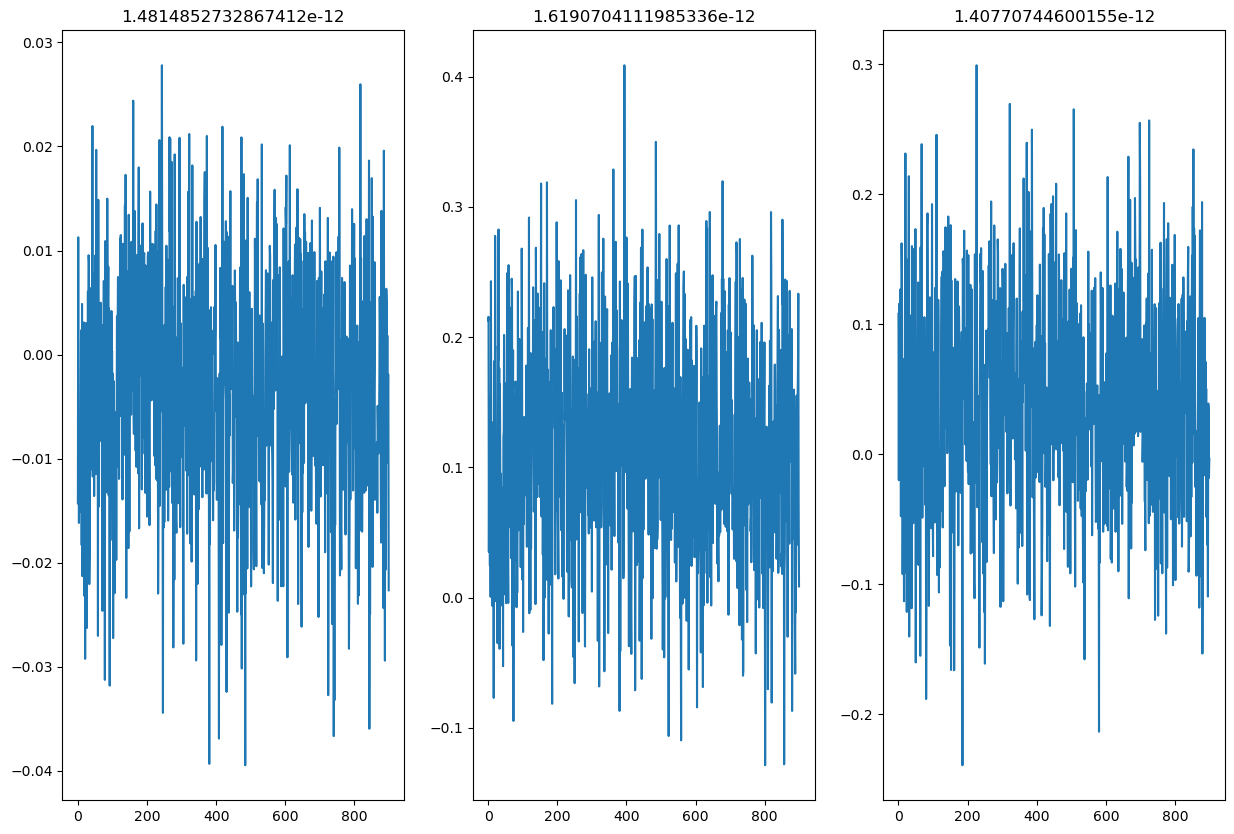

In [281]:
fig, axes = plt.subplots(ncols = 3, figsize = (15,10))
for i in range(0,3):
    axes[i].plot(LFCs[:,i])
    axes[i].set_title(str(fraction[i]*100))
